# Loss Landscapes for CNNs
In this notebook, we show how Landscaper can be used to analyze a CNN trained on the CIFAR-10 dataset. 
(From https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# might have issues with too many files being opened at once, this will prevent that
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
# Check if CUDA is available
device = "cpu"

In [4]:
# load in the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# setup the model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.818
[1,  6000] loss: 1.660
[1,  8000] loss: 1.567
[1, 10000] loss: 1.515
[1, 12000] loss: 1.474
[2,  2000] loss: 1.413
[2,  4000] loss: 1.397
[2,  6000] loss: 1.327
[2,  8000] loss: 1.317
[2, 10000] loss: 1.314
[2, 12000] loss: 1.276
Finished Training


In [9]:
PATH = './cifar_net.pth'

In [10]:
torch.save(net.state_dict(), PATH)

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [11]:
trunc_data = []
for idx, d in enumerate(testloader):
    trunc_data.append(d)    
    if idx > 5:
        break

# Analyzing the loss landscape

In [96]:
from landscaper import LossLandscape, PyHessian

In [97]:
hessian_comp = PyHessian(net, criterion, trunc_data, "cpu")

In [98]:
def loss_function(model, data):
    batch_loss = 0
    for d in data: 
        tt, lbl_t = d
        output = model.forward(tt)
        loss = criterion(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [102]:
with torch.backends.cudnn.flags(enabled=False):
    evals, evecs = hessian_comp.eigenvalues(top_n=3)
print(evals)
print(evecs)

[20.68671417236328, 18.944557189941406, 15.034444808959961]
[[tensor([[[[-3.1431e-03, -5.0209e-03, -4.0331e-03, -5.8284e-03, -1.0421e-02],
          [-4.8448e-03, -5.7436e-03, -6.3836e-03, -9.2292e-03, -1.4096e-02],
          [-2.8177e-03, -3.4506e-03, -3.8680e-03, -6.9504e-03, -1.1289e-02],
          [-5.7645e-04, -1.1683e-03, -7.6730e-04, -2.9046e-03, -6.4291e-03],
          [ 1.8817e-04,  4.3032e-04,  1.2548e-03, -2.1354e-03, -5.5079e-03]],

         [[-3.2875e-03, -5.1584e-03, -4.3444e-03, -6.3683e-03, -1.0897e-02],
          [-5.5594e-03, -6.9813e-03, -7.7789e-03, -1.0968e-02, -1.5886e-02],
          [-3.6282e-03, -5.3155e-03, -6.4256e-03, -9.8207e-03, -1.4337e-02],
          [-1.4616e-03, -3.3104e-03, -4.0347e-03, -6.6205e-03, -9.9566e-03],
          [-9.4726e-04, -1.5285e-03, -1.6338e-03, -5.0491e-03, -8.0505e-03]],

         [[-2.4392e-03, -4.2827e-03, -3.6494e-03, -5.8459e-03, -1.0410e-02],
          [-4.7897e-03, -6.1316e-03, -7.1088e-03, -1.0423e-02, -1.5529e-02],
          

In [103]:
print(evals)
print(evecs)

[20.68671417236328, 18.944557189941406, 15.034444808959961]
[[tensor([[[[-3.1431e-03, -5.0209e-03, -4.0331e-03, -5.8284e-03, -1.0421e-02],
          [-4.8448e-03, -5.7436e-03, -6.3836e-03, -9.2292e-03, -1.4096e-02],
          [-2.8177e-03, -3.4506e-03, -3.8680e-03, -6.9504e-03, -1.1289e-02],
          [-5.7645e-04, -1.1683e-03, -7.6730e-04, -2.9046e-03, -6.4291e-03],
          [ 1.8817e-04,  4.3032e-04,  1.2548e-03, -2.1354e-03, -5.5079e-03]],

         [[-3.2875e-03, -5.1584e-03, -4.3444e-03, -6.3683e-03, -1.0897e-02],
          [-5.5594e-03, -6.9813e-03, -7.7789e-03, -1.0968e-02, -1.5886e-02],
          [-3.6282e-03, -5.3155e-03, -6.4256e-03, -9.8207e-03, -1.4337e-02],
          [-1.4616e-03, -3.3104e-03, -4.0347e-03, -6.6205e-03, -9.9566e-03],
          [-9.4726e-04, -1.5285e-03, -1.6338e-03, -5.0491e-03, -8.0505e-03]],

         [[-2.4392e-03, -4.2827e-03, -3.6494e-03, -5.8459e-03, -1.0410e-02],
          [-4.7897e-03, -6.1316e-03, -7.1088e-03, -1.0423e-02, -1.5529e-02],
          

In [104]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
    net,
    trunc_data,
    evecs,
    loss_function, # loss function
    dim=2,
    distance = 0.01,
    device=device,
)

Computing 1681 points in 2D space...


Computing 2D landscape: 100%|███████████████████████| 169/169 [00:04<00:00, 34.75it/s]

Loss hypercube stats - min: 8.362078666687012, max: 8.440289497375488, mean: 8.400552688362625


In [105]:
landscape.save("cnn.npz")

In [106]:
landscape  = LossLandscape.load_from_npz("cnn.npz")

Attempting log-scale surface plot...


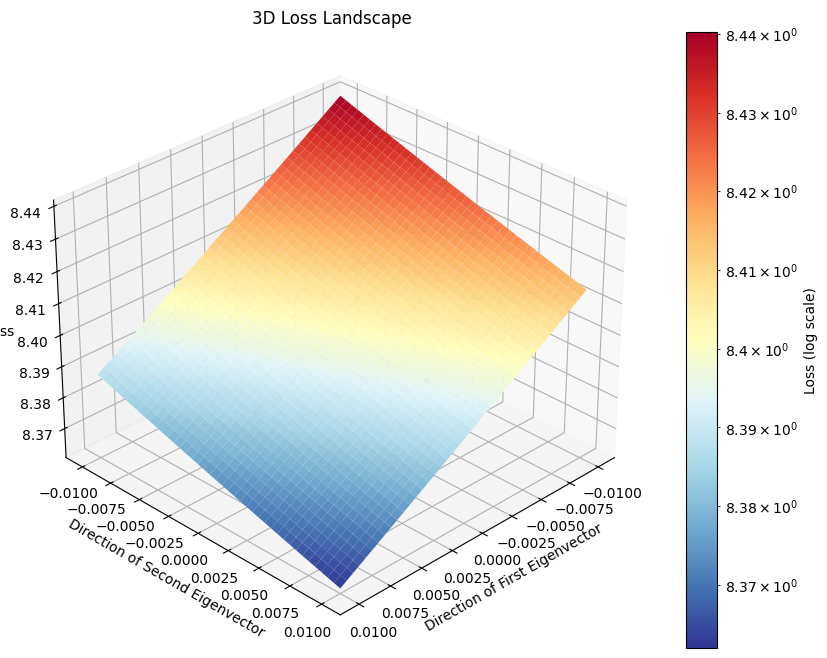

In [107]:
landscape.show()

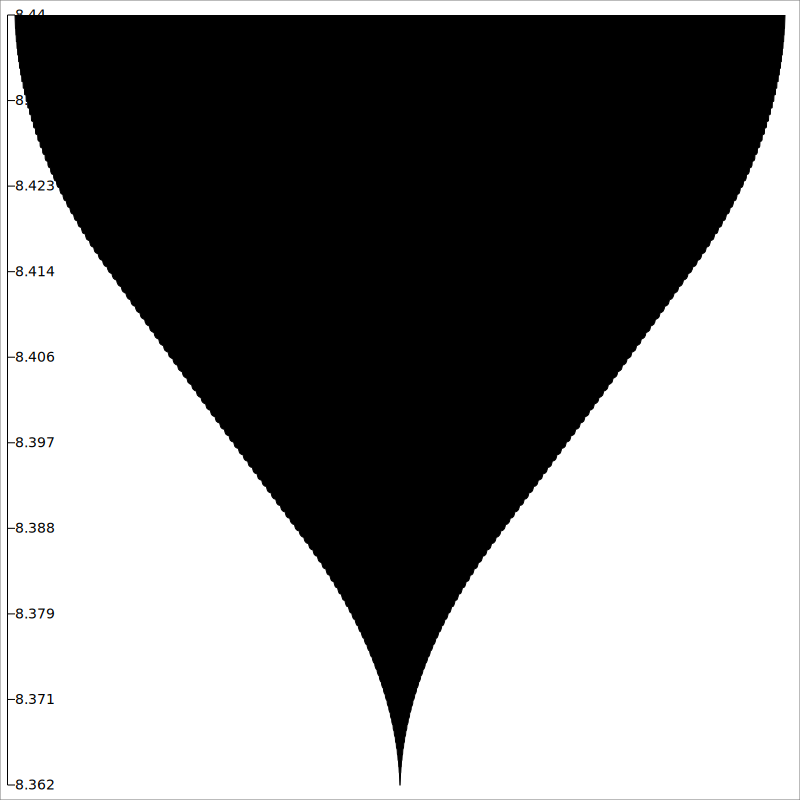

In [108]:
landscape.show_profile()

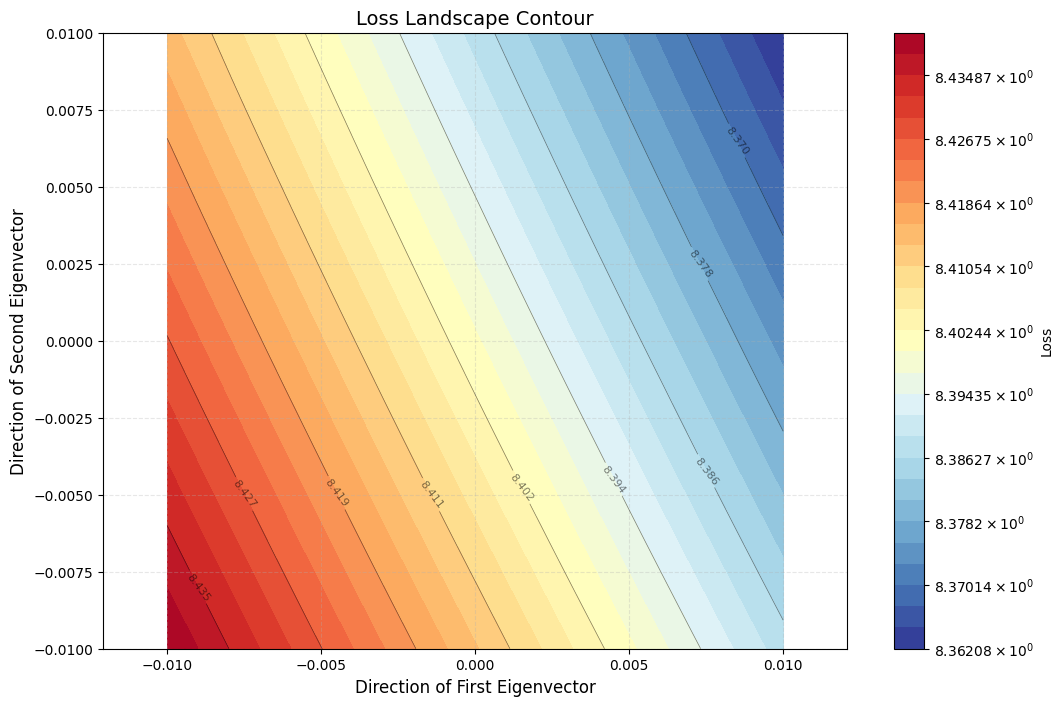

In [109]:
landscape.show_contour()

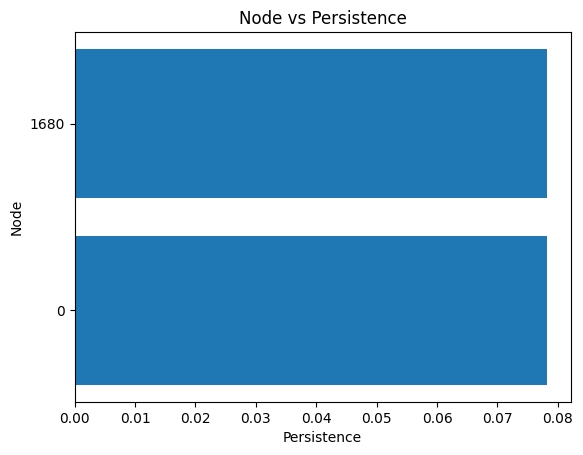

In [110]:
landscape.show_persistence_barcode()

In [111]:
# we can use this function to convert the merge tree 
# into a networkx graph and visualize it!
from landscaper.tda import digraph_mt
g = digraph_mt(landscape.get_sublevel_tree())

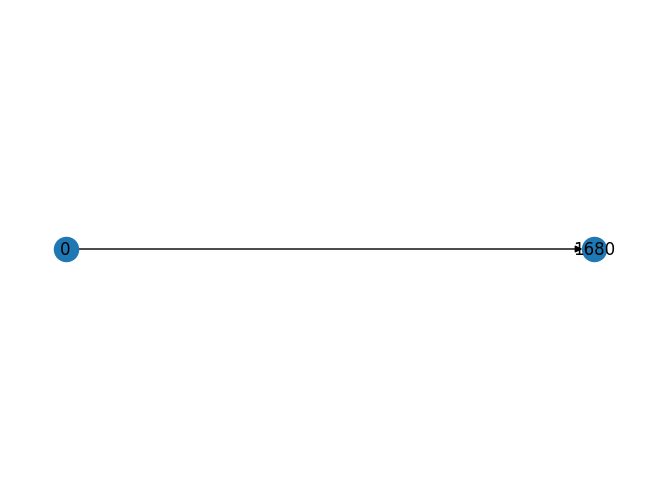

In [112]:
import networkx as nx
nx.draw_planar(g, with_labels=True)

In [113]:
landscape.smad()

0.0